<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/XGBoost/03_tune_xgboost_max_delta_step_parameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
from unicodedata import normalize

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    KFold
)

from sklearn.metrics import (mean_absolute_error)

from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# **Info**
**@By**: Steven Bernal Tovar

**@Nickname**: Kaiziferr

**@Git**: https://github.com/Kaiziferr


**Data information**

This data was downloaded from the Hass Avocado Board website in May of 2018 & compiled into a single CSV. Here's how the Hass Avocado Board describes the data on their website:

**Source**
path data: http://www.hassavocadoboard.com/retail/volume-and-price-data



- **Date** - The date of the observation
- **AveragePrice** - the average price of a single avocado
- **type** - conventional or organic
- **year** - the year
- **Region** - the city or region of the observation
- **Total Volume** - Total number of avocados sold
- **4046** - Total number of avocados with PLU 4046 sold
- **4225** - Total number of avocados with PLU 4225 sold
- **4770** - Total number of avocados with PLU 4770 sold


https://loveonetoday.com/how-to/identify-hass-avocados/

- The objective of the model is to predict Total Volumnen

# **Config**
---

In [ ]:
sns.set(style="darkgrid")
pd.set_option('display.float_format', '{:,.2f}'.format)
title_data = 'Avocado Price'
paleta = sns.color_palette('Set2').as_hex()
random_seed=73
warnings.filterwarnings("ignore")
np.set_printoptions(precision=3, suppress=True)

# **Funtions**
---

In [ ]:
def normalize_word(word)->str:
  """Normaliza palabras"""
  word = word.replace(' ', '_')
  find_guion = word.find('_')
  list_word = []
  if find_guion:
    list_word = [w for w in word.split('_') if w != '']
  else:
    list_word = word
  word = list(map(lambda x: x.lower(), list_word))
  word = [normalize('NFKD', c).encode('ASCII', 'ignore').decode() for c in word]
  word = "_".join(word)
  return word


def normalize_name_columns(columns):
  """Normaliza columnas"""
  columns = list(map(lambda x: normalize_word(x), columns))
  return columns

def porcentaje_nulos_x_caracteristica(data:pd.DataFrame, **kwargs)->None:
  """Calcular el porcentaje de valores nulos por caracteristicas"""
  data.isnull().melt().pipe(
        lambda df: (
            sns.displot(
                data=df,
                y='variable',
                hue='value',
                multiple='fill',
                aspect=2
            ).set(**kwargs)
        )
    )

def agrupamiento(
    function_dictionary:dict,
    filter_feature:list,
    new_val_col:list,
    data):
  try:
    data_group = data.groupby(
    filter_feature).aggregate(function_dictionary)

    data_group.columns =  new_val_col
    data_group = data_group.reset_index()
    return data_group
  except Exception as e:
    print(e)

# **Data**
---

In [ ]:
url_master =  'https://drive.google.com/uc?id='
url_price = 'https://drive.google.com/file/d/1P-rHjYlzRplwz5jtKUcgxJ5cR-ryB0LV/view?usp=sharing'
url_price = url_master + url_price.split('/')[-2]
data_avocado_price = pd.read_csv(url_price, dtype=str)
data_avocado_price.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.7,109149.67,130.5,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.0,71976.41,72.58,5811.16,5677.4,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.6,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


- Change the actual data type

In [ ]:
data_avocado_price[[
    'AveragePrice',
    'Total Volume',
    '4046',
    '4225',
    '4770',
    'Total Bags',
    'Small Bags',
    'Large Bags',
    'XLarge Bags',
    ]] =  data_avocado_price[[
    'AveragePrice',
    'Total Volume',
    '4046',
    '4225',
    '4770',
    'Total Bags',
    'Small Bags',
    'Large Bags',
    'XLarge Bags',
    ]].astype('float64')

data_avocado_price[[
    'year'
    ]] =  data_avocado_price[[
    'year'
    ]].astype('int32')

In [ ]:
data_avocado_price['Date'] = pd.to_datetime(
    data_avocado_price['Date']
)

In [ ]:
data_avocado_price['month'] = data_avocado_price['Date'].dt.month

In [ ]:
data_avocado_price['year'].unique()

array([2015, 2016, 2017, 2018], dtype=int32)

The dates of two years were used. In 2016 and 2018. To use the year 2018 as test data

In [ ]:
mask = (data_avocado_price['year'] > 2015) & (data_avocado_price['year'] < 2018)
data_avocado_price_train = data_avocado_price[mask]

In [ ]:
data_avocado_price_train.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,month
2808,0,2016-12-25,1.52,"73,341.73","3,202.39","58,280.33",426.92,"11,432.09","11,017.32",411.83,2.94,conventional,2016,Albany,12
2809,1,2016-12-18,1.53,"68,938.53","3,345.36","55,949.79",138.72,"9,504.66","8,876.65",587.73,40.28,conventional,2016,Albany,12
2810,2,2016-12-11,1.49,"71,777.85","2,323.39","56,545.79",86.65,"12,822.02","12,176.75",645.27,0.00,conventional,2016,Albany,12
2811,3,2016-12-04,1.48,"113,031.96","6,530.78","99,746.05",50.84,"6,704.29","6,476.12",228.17,0.00,conventional,2016,Albany,12
2812,4,2016-11-27,1.52,"58,171.89","2,793.99","47,106.18",18.14,"8,253.58","7,973.98",279.60,0.00,conventional,2016,Albany,11


In [ ]:
data_avocado_price_train['region'].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

# **Preprocessing**

In [ ]:
function_dictionary = {
    "Total Volume": ['sum'],
    "4046": ['sum'],
    '4225': ['sum'],
    '4770': ['sum'],
    'Total Bags': ['sum'],
}

filter_feature = [
    'month',
    'year',
    'region',
    'type']


new_val_col  = [
    "total_volumen_sum",
    "4046_sum",
    '4225_sum',
    '4770_sum',
    'total_bags'
]
data_group = agrupamiento(
    function_dictionary,
    filter_feature,
    new_val_col,
    data_avocado_price_train
)

data_group

,month,year,region,type,total_volumen_sum,4046_sum,4225_sum,4770_sum,total_bags
0,1,2016,Albany,conventional,"546,259.78","4,922.03","457,730.56",430.52,"83,176.67"
1,1,2016,Albany,organic,"7,131.09",166.43,"1,428.23",0.00,"5,536.43"
2,1,2016,Atlanta,conventional,"2,418,969.35","1,645,108.06","291,981.19","2,328.72","479,551.38"
3,1,2016,Atlanta,organic,"31,580.06","13,255.97","11,325.41",0.00,"6,998.68"
4,1,2016,BaltimoreWashington,conventional,"4,204,725.93","296,012.20","2,825,276.88","128,113.25","955,323.60"
...,...,...,...,...,...,...,...,...,...
2587,12,2017,TotalUS,organic,"5,909,492.73","512,248.31","1,271,243.20","5,517.54","4,118,740.10"
2588,12,2017,West,conventional,"28,679,649.28","9,835,917.93","7,589,673.56","424,376.93","10,829,680.86"
2589,12,2017,West,organic,"1,275,828.27","124,281.14","253,775.16",474.77,"897,297.20"
2590,12,2017,WestTexNewMexico,conventional,"3,802,035.32","1,883,589.43","827,606.95","32,267.48","1,058,571.46"


# **Split**
---

In [ ]:
columns = data_group.select_dtypes(include=['float64', 'int32']).columns.to_list()
columns

['month',
 'year',
 'total_volumen_sum',
 '4046_sum',
 '4225_sum',
 '4770_sum',
 'total_bags']

In [ ]:
X = data_group[columns[3:]]
y = data_group[columns[2]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.75,
    random_state=random_seed)

# **Model**
---

In [ ]:
cv = KFold(n_splits=10, shuffle=True, random_state=random_seed)

In [ ]:
param_grid = {
    'max_delta_step': [0, 1, 5, 10, 100]
}


model = XGBRegressor(
    n_estimators = 100,
    learning_rate=0.1,
    random_state=random_seed
)

In [ ]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid = param_grid,
    cv = cv,
    scoring='neg_mean_squared_error',
    verbose=1
)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=73, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    int...
                                    learning_rate=0.1, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=73, ...),
             param_grid={'max_delta_step': [0, 1, 5, 10, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
print(f"Best max_delta_step, {grid_search.best_params_['max_delta_step']}")
print(f"Best CV MSE, {- grid_search.best_score_:.4f}")

Best max_delta_step, 0
Best CV MSE, 2142047630817.2739


In [ ]:
results = grid_search.cv_results_

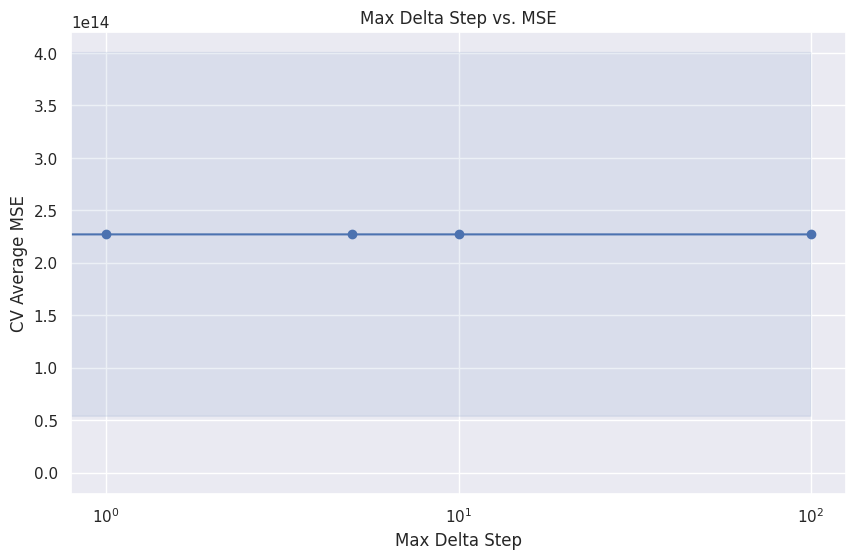

In [ ]:
plt.figure(figsize=(10, 6))
plt.semilogx(param_grid['max_delta_step'], -results['mean_test_score'], marker='o', linestyle='-', color='b')
plt.fill_between(param_grid['max_delta_step'], -results['mean_test_score'] + results['std_test_score'],
                 -results['mean_test_score'] - results['std_test_score'], alpha=0.1, color='b')
plt.title('Max Delta Step vs. MSE')
plt.xlabel('Max Delta Step')
plt.ylabel('CV Average MSE')
plt.grid(True)
plt.show()